# 리뷰 기반 QA 시스템 구축하기

## 데이터셋

In [16]:
from datasets import get_dataset_config_names

domains = get_dataset_config_names('subjqa')
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [17]:
from datasets import load_dataset

subjqa = load_dataset('subjqa', name='electronics')

In [18]:
print(subjqa['train']['answers'][1])

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1], 'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective': [True, True]}


In [19]:
import pandas as pd

dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}

for split, df in dfs.items():
    print(f"{split} 에 있는 질문 개수 : {df['id'].nunique()}")

train 에 있는 질문 개수 : 1295
test 에 있는 질문 개수 : 358
validation 에 있는 질문 개수 : 255


In [20]:
qa_cols = ['title', 'question', 'answers.text',
          'answers.answer_start', 'context']
sample_df = dfs['train'][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


In [21]:
start_idx = sample_df['answers.answer_start'].iloc[0][0]
end_idx = start_idx + len(sample_df['answers.text'].iloc[0][0])
sample_df['context'].iloc[0][start_idx:end_idx]

'this keyboard is compact'

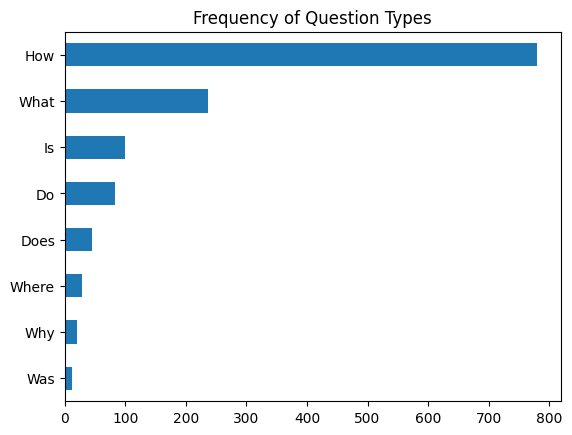

In [22]:
import matplotlib.pyplot as plt 

counts = {}
question_types = ['What', 'How', 'Is', 'Does',
                 'Do', 'Was', 'Where', 'Why']

for q in question_types:
    counts[q] = dfs['train']['question'].str.startswith(q).value_counts()[True]
    
pd.Series(counts).sort_values().plot.barh()
plt.title('Frequency of Question Types')
plt.show()

In [23]:
for question_type in ['How', 'What', 'Is']:
    for question in (dfs['train'][dfs['train'].question.str.startswith(question_type)].sample(n=3, random_state=42)['question']):
        print(question)

How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?


## 텍스트에서 답 추출하기

**QA를 위한 텍스트 토큰화**

In [24]:
from transformers import AutoTokenizer

model_ckpt = 'deepset/minilm-uncased-squad2'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [25]:
question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on \
file size."""
inputs = tokenizer(question, context, return_tensors='pt')
inputs

{'input_ids': tensor([[  101,  2129,  2172,  2189,  2064,  2023,  2907,  1029,   102,  2019,
         23378,  2003,  2055,  1015, 16914,  1013,  3371,  1010,  2061,  2055,
         25961,  2847,  5834,  2006,  5371,  2946,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]])}

In [26]:
input_df = pd.DataFrame.from_dict(tokenizer(question, context), orient="index")
input_df

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
input_ids,101,2129,2172,2189,2064,2023,2907,1029,102,2019,...,2061,2055,25961,2847,5834,2006,5371,2946,1012,102
token_type_ids,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1
attention_mask,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [27]:
tokenizer.decode(inputs['input_ids'][0])

'[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so about 6000 hours depending on file size. [SEP]'

In [28]:
import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
    outputs = model(**inputs)

Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [29]:
print(outputs)

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750, -5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3108, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623, -5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0161, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None, attentions=None)


In [30]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits

In [31]:
print(f"입력 ID 크기: {inputs.input_ids.size()}")
print(f"시작 로짓 크기: {start_logits.size()}")
print(f"종료 로짓 크기: {end_logits.size()}")

입력 ID 크기: torch.Size([1, 28])
시작 로짓 크기: torch.Size([1, 28])
종료 로짓 크기: torch.Size([1, 28])


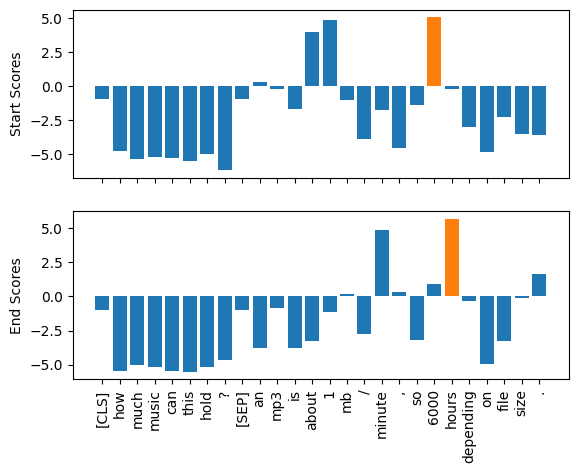

In [32]:
# 시작 토큰과 종료 토큰에 대한 예측 로짓. 오렌지 색 토큰이 가장 높은 점수를 가진 토큰입니다.
# 이 그래프는 다음을 참고했습니다. https://mccormickml.com/2020/03/10/question-answering-with-a-fine-tuned-BERT
import numpy as np
import matplotlib.pyplot as plt

s_scores = start_logits.detach().numpy().flatten()
e_scores = end_logits.detach().numpy().flatten()
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
colors = ["C0" if s != np.max(s_scores) else "C1" for s in s_scores]
ax1.bar(x=tokens, height=s_scores, color=colors)
ax1.set_ylabel("Start Scores")
colors = ["C0" if s != np.max(e_scores) else "C1" for s in e_scores]
ax2.bar(x=tokens, height=e_scores, color=colors)
ax2.set_ylabel("End Scores")
plt.xticks(rotation="vertical")
plt.show()

In [33]:
import torch

start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits)
answer_span = inputs['input_ids'][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f"질문: {question}")
print(f"답변: {answer}")

질문: How much music can this hold?
답변: 6000


In [34]:
question

'How much music can this hold?'

In [35]:
context

'An MP3 is about 1 MB/minute, so about 6000 hours depending on file size.'

In [36]:
from transformers import pipeline

pipe = pipeline('question-answering', model=model, tokenizer=tokenizer)
pipe(question=question, context=context, topk=2)

/home/restful3/anaconda3/envs/trading/lib/python3.10/site-packages/transformers/pipelines/question_answering.py:326: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.2651616334915161, 'start': 38, 'end': 48, 'answer': '6000 hours'},
 {'score': 0.22082962095737457,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'}]

In [37]:
pipe(question="Why is there no data?", context=context,
     handle_impossible_answer=True)

{'score': 0.9068413972854614, 'start': 0, 'end': 0, 'answer': ''}

**긴 텍스트 다루기**

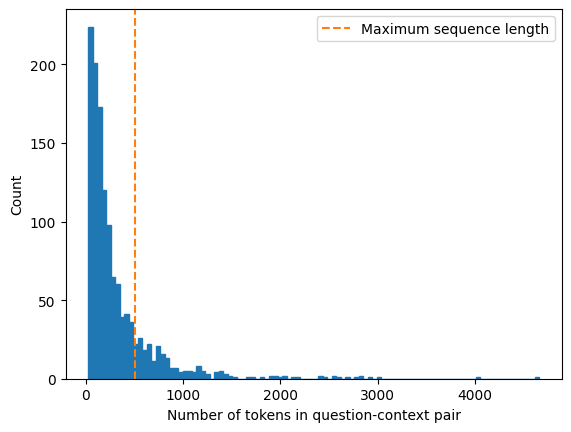

In [38]:
# SubjQA 훈련 세트에 있는 질문-문맥 쌍의 토큰 분포
def compute_input_length(row):
    inputs = tokenizer(row["question"], row["context"])
    return len(inputs["input_ids"])

dfs["train"]["n_tokens"] = dfs["train"].apply(compute_input_length, axis=1)

fig, ax = plt.subplots()
dfs["train"]["n_tokens"].hist(bins=100, grid=False, ec="C0", ax=ax)
plt.xlabel("Number of tokens in question-context pair")
ax.axvline(x=512, ymin=0, ymax=1, linestyle="--", color="C1",
           label="Maximum sequence length")
plt.legend()
plt.ylabel("Count")
plt.show()

In [39]:
example = dfs['train'].iloc[0][["question", "context"]]
tokenized_example = tokenizer(example['question'], example['context'], 
                             return_overflowing_tokens=True, max_length=100, stride=25)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [40]:
for idx, window in enumerate(tokenized_example["input_ids"]):
    print(f"#{idx} 윈도에는 {len(window)}개의 토큰이 있습니다.")

#0 윈도에는 100개의 토큰이 있습니다.
#1 윈도에는 88개의 토큰이 있습니다.


In [41]:
for window in tokenized_example['input_ids']:
    print(f'{tokenizer.decode(window)}\n')

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and qz - 99. the koss portapro is portable and has great bass response. the work great with my android phone and can be " rolled up " to be carried in my motorcycle jacket or computer bag without getting crunched. they are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is [SEP]

[CLS] how is the bass? [SEP] and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is night and day better than any ear - bud could be and are almost as good as the pro 4aa. they are " open air " headphones so you cannot match the bass to the sealed types, but it comes close. for $ 32, you cannot go wrong. [SEP]



## 헤이스택을 사용해 QA 파이프라인 구축하기

**문서 저장소 초기화하기**

- [우분투에 elasticsearch 설치하기](https://hwanstory.kr/@kim-hwan/posts/ELK-Stack-Install)

In [42]:
!curl -X GET "localhost:9200/?pretty"

{
  "name" : "msi",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "U1Ni4yAQSd6TnaLdd7uVMA",
  "version" : {
    "number" : "7.17.18",
    "build_flavor" : "default",
    "build_type" : "deb",
    "build_hash" : "8682172c2130b9a411b1bd5ff37c9792367de6b0",
    "build_date" : "2024-02-02T12:04:59.691750271Z",
    "build_snapshot" : false,
    "lucene_version" : "8.11.1",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [43]:
# !pip install elasticsearch-haystack

In [55]:
import haystack

print(haystack.__version__)

1.25.0


In [50]:
from haystack.document_stores.elasticsearch import ElasticsearchDocumentStore

# 밀집 리트리버에서 사용할 문서 임베딩을 반환합니다.
document_store = ElasticsearchDocumentStore(return_embedding=True)

In [51]:
# 노트북을 다시 시작할 때 일래스틱서치 저장소를 모두 비우는 것이 좋습니다.
if len(document_store.get_all_documents()) or len(document_store.get_all_labels()) > 0:
    document_store.delete_documents("document")
    document_store.delete_documents("label")

In [53]:
for split, df in dfs.items():
    # 중복 리뷰를 제외시킵니다
    docs = [{"text": row["context"],
             "content": row["context"],  # 'content' 필드 추가
             "meta": {"item_id": row["title"], "question_id": row["id"],
                      "split": split}}
            for _, row in df.drop_duplicates(subset="context").iterrows()]
    document_store.write_documents(docs, index="document")
    
print(f"{document_store.get_document_count()}개 문서가 저장되었습니다")

1615개 문서가 저장되었습니다


In [60]:
import haystack
dir(haystack)

['Answer',
 'BaseComponent',
 'Document',
 'EvaluationResult',
 'Label',
 'MultiLabel',
 'Pipeline',
 'Span',
 'TableCell',
 '__annotations__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 'document_stores',
 'environment',
 'errors',
 'hash128',
 'haystack',
 'lazy_imports',
 'metadata',
 'mmh3',
 'modeling',
 'nodes',
 'pipelines',
 'schema',
 'set_pytorch_secure_model_loading',
 'silenceable_tqdm',
 'telemetry',
 'utils']

In [61]:
from haystack import nodes

In [62]:
dir(nodes)

['AnswerParser',
 'AzureConverter',
 'BM25Retriever',
 'BaseComponent',
 'BaseConverter',
 'BaseDocumentClassifier',
 'BaseOutputParser',
 'BasePreProcessor',
 'BaseRanker',
 'BaseReader',
 'BaseRetriever',
 'BaseSampler',
 'BaseSummarizer',
 'BaseTranslator',
 'CohereRanker',
 'Crawler',
 'CsvTextConverter',
 'DensePassageRetriever',
 'DenseRetriever',
 'DiversityRanker',
 'Docs2Answers',
 'DocumentMerger',
 'DocxToTextConverter',
 'EmbeddingRetriever',
 'EntityExtractor',
 'FARMReader',
 'FileTypeClassifier',
 'FilterRetriever',
 'ImageToTextConverter',
 'JoinAnswers',
 'JoinDocuments',
 'JsonConverter',
 'LangdetectDocumentLanguageClassifier',
 'LinkContentFetcher',
 'LostInTheMiddleRanker',
 'MarkdownConverter',
 'MultiModalRetriever',
 'MultihopEmbeddingRetriever',
 'PDFToTextConverter',
 'ParsrConverter',
 'PptxConverter',
 'PreProcessor',
 'PromptModel',
 'PromptModelInvocationLayer',
 'PromptNode',
 'PromptTemplate',
 'PseudoLabelGenerator',
 'QuestionGenerator',
 'RCIReader',


In [57]:
dir(haystack)

['Answer',
 'BaseComponent',
 'Document',
 'EvaluationResult',
 'Label',
 'MultiLabel',
 'Pipeline',
 'Span',
 'TableCell',
 '__annotations__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 'document_stores',
 'environment',
 'errors',
 'hash128',
 'haystack',
 'lazy_imports',
 'metadata',
 'mmh3',
 'modeling',
 'nodes',
 'pipelines',
 'schema',
 'set_pytorch_secure_model_loading',
 'silenceable_tqdm',
 'telemetry',
 'utils']

In [74]:
from haystack.nodes import BM25Retriever

es_retriever = BM25Retriever(document_store=document_store)

item_id = "B0074BW614"
query = "Is it good for reading?"
retrieved_docs = es_retriever.retrieve(query=query, top_k=3, filters={'item_id':[item_id], 'split':['train']})

retrieved_docs[0]

<Document: {'content': 'This is a gift to myself.  I have been a kindle user for 4 years and this is my third one.  I never thought I would want a fire for I mainly use it for book reading.  I decided to try the fire for when I travel I take my laptop, my phone and my iPod classic.  I love my iPod but watching movies on the plane with it can be challenging because it is so small. Laptops battery life is not as good as the Kindle.  So the Fire combines for me what I needed all three to do. So far so good.', 'content_type': 'text', 'score': 0.6857824513476455, 'meta': {'item_id': 'B0074BW614', 'question_id': '868e311275e26dbafe5af70774a300f3', 'split': 'train', 'text': 'This is a gift to myself.  I have been a kindle user for 4 years and this is my third one.  I never thought I would want a fire for I mainly use it for book reading.  I decided to try the fire for when I travel I take my laptop, my phone and my iPod classic.  I love my iPod but watching movies on the plane with it can be 

**리트리버 초기화하기**

In [78]:
from haystack.nodes import FARMReader

model_ckpt = 'deepset/minilm-uncased-squad2'
max_seq_length, doc_stride = 384, 128
reader = FARMReader(model_name_or_path=model_ckpt, 
                    progress_bar=False,
                   max_seq_len=max_seq_length, doc_stride=doc_stride,
                   return_no_answer=True)

In [83]:
print(reader.predict_on_texts(question=question, texts=[context], top_k=1))

{'query': 'How much music can this hold?', 'no_ans_gap': 12.648090839385986, 'answers': [<Answer {'answer': '6000 hours', 'type': 'extractive', 'score': 0.5293056964874268, 'context': 'An MP3 is about 1 MB/minute, so about 6000 hours depending on file size.', 'offsets_in_document': [{'start': 38, 'end': 48}], 'offsets_in_context': [{'start': 38, 'end': 48}], 'document_ids': ['e344757014e804eff50faa3ecf1c9c75'], 'meta': {}}>]}


**모두 합치기**

In [84]:
from haystack.pipelines import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(reader, es_retriever)

In [100]:
n_answers = 3
preds = pipe.run(
    query=query, params={"Retriever": {"top_k": n_answers}, "Reader": {"top_k": n_answers}, 
                        "filters":{"item_id": [item_id], "split":["train"]}}
)

In [102]:
preds

{'query': 'Is it good for reading?',
 'no_ans_gap': 13.715798377990723,
 'answers': [<Answer {'answer': 'it is great for reading books when no light is available', 'type': 'extractive', 'score': 0.5443060994148254, 'context': 'ecoming addicted to hers! Our son LOVES it and it is great for reading books when no light is available. Amazing sound but I suggest good headphones t', 'offsets_in_document': [{'start': 216, 'end': 272}], 'offsets_in_context': [{'start': 47, 'end': 103}], 'document_ids': ['41f4a1710c6f3be65c7814326b662ab6'], 'meta': {'item_id': 'B0074BW614', 'question_id': '998d564607f10bf6dbbd20b33b8fbbf1', 'split': 'train', 'text': 'Plays Netflix great, WiFi capability has great range. Resolution on the screen is AMAZING! For the price you cannot go wrong. Bought one for my spouse and myself after becoming addicted to hers! Our son LOVES it and it is great for reading books when no light is available. Amazing sound but I suggest good headphones to really hear it all.Battery li

In [104]:
print(f"질문: {preds['query']} \n")
for idx in range(len(preds['answers'])):
    answer = preds['answers'][idx].answer
    context = preds['answers'][idx].context
    print(f"답변 {idx+1}: {answer}")
    print(f"해당 리뷰 텍스트: ...{context}...")
    print("\n\n")

질문: Is it good for reading? 

답변 1: it is great for reading books when no light is available
해당 리뷰 텍스트: ...ecoming addicted to hers! Our son LOVES it and it is great for reading books when no light is available. Amazing sound but I suggest good headphones t...



답변 2: I mainly use it for book reading
해당 리뷰 텍스트: ... is my third one.  I never thought I would want a fire for I mainly use it for book reading.  I decided to try the fire for when I travel I take my la...



답변 3: 
해당 리뷰 텍스트: ...None...





# QA 파이프라인 개선하기

## 리트리버 평가하기

**DPR**

## 리더 평가하기

## 도메인 적응

## 전체 QA 파이프라인 평가하기

# 추출적 QA를 넘어서